# MCMC for GPR
MCMC to sample the hyperparameters of a simple Gaussian process regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

tf.random.set_seed(123)

%matplotlib inline

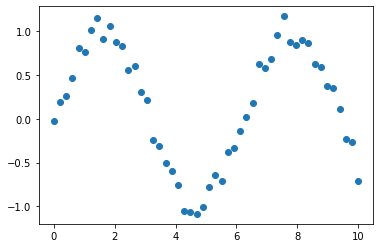

In [23]:
n_points = 50
gaussian_noise_var = 0.1

X = np.linspace(0, 10, n_points)
Y = np.sin(X) + np.random.normal(0, gaussian_noise_var, n_points)
Z = np.linspace(0, 10, 10)
#X = tf.Variable(X)
#Y = tf.Variable(Y)

data = (X[:, None], Y[:, None])

plt.scatter(X, Y)

In [25]:
kernel = gpflow.kernels.Matern52(1)
likelihood = gpflow.likelihoods.Gaussian()
model = gpflow.models.SGPMC(data, kernel, likelihood)
model

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [4]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables)
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.42977
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.6425
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01056


In [5]:
model.kernel.lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.likelihood.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

In [16]:
num_burnin_steps = ci_niter(500)
num_samples = ci_niter(4000)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, traces = run_chain_fn()
parameter_samples = hmc_helper.convert_to_constrained_values(samples)

param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}

In [22]:
param_to_name[model.trainable_parameters[2]]

'.likelihood.variance'

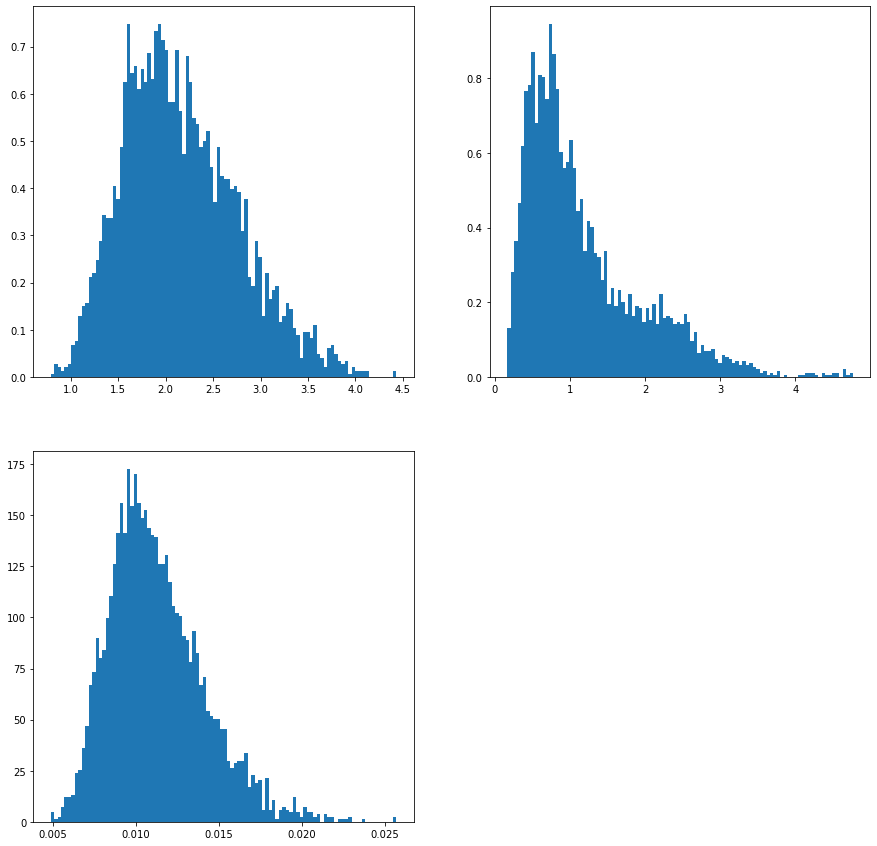

In [18]:
plt.figure(figsize = (15, 15))
plt.subplot(221)
plt.hist(parameter_samples[0].numpy(), 100, density = True)

plt.subplot(222)
plt.hist(parameter_samples[1].numpy(), 100, density = True)

plt.subplot(223)
plt.hist(parameter_samples[2].numpy(), 100, density = True)
plt.show()